Import library yang dibutuhkan

In [1]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

Unggah file zip ke google colab

In [3]:
from google.colab import files

files.upload()

Saving images.zip to images.zip


Extract file zip ke direktori content

In [4]:
import zipfile
import os

zip_path = '/content/images.zip'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content/')

# os.remove(zip_path)

# Pre-processing Image

Mengecek total foto training dan validasi

In [5]:
training_dir = '/content/images/train/'
validation_dir = '/content/images/validation/'

for folder in os.listdir(training_dir):
    item_path = os.path.join(training_dir, folder)

    print(f'Total foto training {folder}: {len(os.listdir(item_path))}')

print('\n')

for folder in os.listdir(validation_dir):
    item_path = os.path.join(validation_dir, folder)

    print(f'Total foto validasi {folder}: {len(os.listdir(item_path))}')

Total foto training disgust: 436
Total foto training sad: 4938
Total foto training surprise: 3205
Total foto training fear: 4103
Total foto training angry: 3993
Total foto training neutral: 4982
Total foto training happy: 7164


Total foto validasi disgust: 111
Total foto validasi sad: 1139
Total foto validasi surprise: 797
Total foto validasi fear: 1018
Total foto validasi angry: 960
Total foto validasi neutral: 1216
Total foto validasi happy: 1825


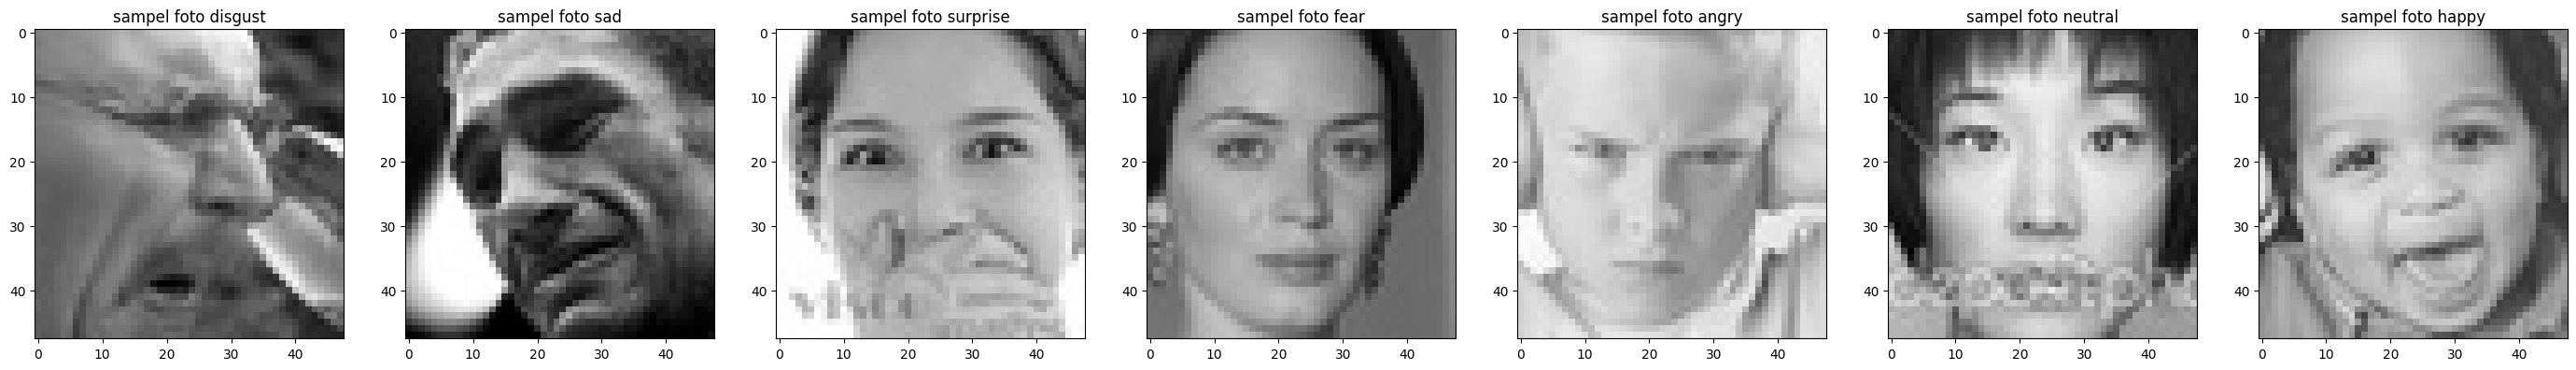

In [6]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 7, figsize=(7 * 5, 5))
for i, folder in enumerate(os.listdir(training_dir)):
    item_path = os.path.join(training_dir, folder)
    sample_image = load_img(f'{os.path.join(item_path, os.listdir(item_path)[0])}')
    axs[i].imshow(sample_image)
    axs[i].set_title(f'sampel foto {folder}')
plt.show()

Cek shape dari foto

In [7]:
for folder in os.listdir(training_dir):
    item_path = os.path.join(training_dir, folder)
    sample_image = load_img(f'{os.path.join(item_path, os.listdir(item_path)[0])}')
    sample_array = img_to_array(sample_image)
    print(f'Setiap foto {folder} memiliki pixel : {sample_array.shape}')

Setiap foto disgust memiliki pixel : (48, 48, 3)
Setiap foto sad memiliki pixel : (48, 48, 3)
Setiap foto surprise memiliki pixel : (48, 48, 3)
Setiap foto fear memiliki pixel : (48, 48, 3)
Setiap foto angry memiliki pixel : (48, 48, 3)
Setiap foto neutral memiliki pixel : (48, 48, 3)
Setiap foto happy memiliki pixel : (48, 48, 3)


Menggunakan ImageDataGenerator untuk pemberian label berdasarkan direktori

In [8]:
def train_val_generators(train_dir, val_dir):
  train_datagen = ImageDataGenerator(rescale = 1.0 / 255.0,
                                     rotation_range=20,
                                     width_shift_range=0.3,
                                     height_shift_range=0.3,
                                     shear_range=0.2,
                                     zoom_range=0.2,
                                     horizontal_flip=True,
                                     fill_mode='nearest')

  train_generator = train_datagen.flow_from_directory(directory = train_dir,
                                                      batch_size = 128,
                                                      class_mode = 'categorical',
                                                      target_size = (48, 48))

  val_datagen = ImageDataGenerator(rescale = 1.0 / 255.0)

  val_generator = val_datagen.flow_from_directory(directory = val_dir,
                                                  batch_size = 128,
                                                  class_mode = 'categorical',
                                                  target_size = (48, 48))

  return train_generator, val_generator

train_generator, val_generator = train_val_generators(training_dir, validation_dir)

Found 28821 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.


# Building Model


Membuat model menggunakan tensorflow.keras.models.Sequentials

In [9]:
from tensorflow.keras.optimizers import Adam

def create_model():
  model = models.Sequential([
      layers.Conv2D(64, (3, 3), activation = 'relu', input_shape = (48, 48, 3)),
      layers.MaxPooling2D(2, 2),
      layers.Conv2D(128, (3, 3), activation = 'relu'),
      layers.MaxPooling2D(2, 2),
      layers.Dropout(0.25),
      layers.Conv2D(512, (3, 3), activation = 'relu'),
      layers.MaxPooling2D(2, 2),
      layers.Dropout(0.25),
      layers.Conv2D(512, (3, 3), activation='relu'),
      layers.MaxPooling2D(2, 2),
      layers.Dropout(0.25),
      layers.Flatten(),
      layers.Dense(512, activation = 'relu'),
      layers.Dropout(0.25),
      layers.Dense(128, activation = 'relu'),
      layers.Dropout(0.15),
      layers.Dense(7, activation = 'softmax')
  ])

  model.compile(optimizer = Adam(learning_rate = 0.001),
                loss = 'categorical_crossentropy',
                metrics = ['accuracy'])

  return model

Melihat ringkasan model

In [10]:
model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 23, 23, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 21, 21, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 10, 10, 128)       0         
 g2D)                                                            
                                                                 
 dropout (Dropout)           (None, 10, 10, 128)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 512)         5

Membuat checkpoint yang akan berhenti ketika val_loss meningkat

In [20]:
filepath = 'my_model.h5'

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=False)

checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath,
                    monitor="val_loss", mode="min",
                    save_best_only=True, verbose=1)

Train model

In [21]:
history = model.fit(train_generator,
                    epochs = 30,
                    verbose = 2,
                    validation_data = val_generator,
                    callbacks=[early_stopping, checkpoint])

Epoch 1/30

Epoch 1: val_loss improved from inf to 1.73326, saving model to my_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


226/226 - 1120s - loss: 1.7854 - accuracy: 0.2530 - val_loss: 1.7333 - val_accuracy: 0.2945 - 1120s/epoch - 5s/step
Epoch 2/30

Epoch 2: val_loss improved from 1.73326 to 1.67637, saving model to my_model.h5
226/226 - 1103s - loss: 1.7597 - accuracy: 0.2681 - val_loss: 1.6764 - val_accuracy: 0.3190 - 1103s/epoch - 5s/step
Epoch 3/30

Epoch 3: val_loss improved from 1.67637 to 1.63390, saving model to my_model.h5
226/226 - 1079s - loss: 1.7262 - accuracy: 0.2925 - val_loss: 1.6339 - val_accuracy: 0.3404 - 1079s/epoch - 5s/step
Epoch 4/30

Epoch 4: val_loss improved from 1.63390 to 1.50606, saving model to my_model.h5
226/226 - 1064s - loss: 1.6911 - accuracy: 0.3103 - val_loss: 1.5061 - val_accuracy: 0.4290 - 1064s/epoch - 5s/step
Epoch 5/30

Epoch 5: val_loss improved from 1.50606 to 1.44274, saving model to my_model.h5
226/226 - 1068s - loss: 1.6392 - accuracy: 0.3447 - val_loss: 1.4427 - val_accuracy: 0.4527 - 1068s/epoch - 5s/step
Epoch 6/30

Epoch 6: val_loss improved from 1.44274 

# Evaluate

Plot acc, val_acc dan loss, val_loss

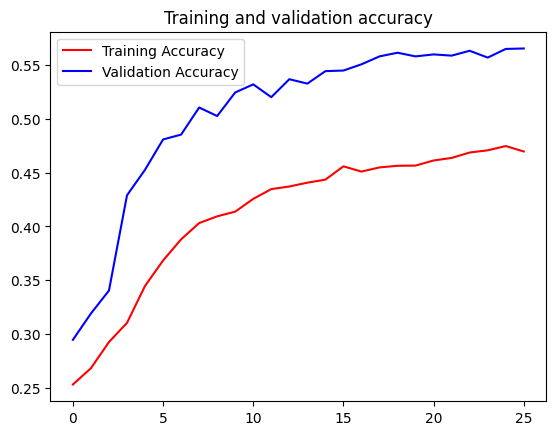

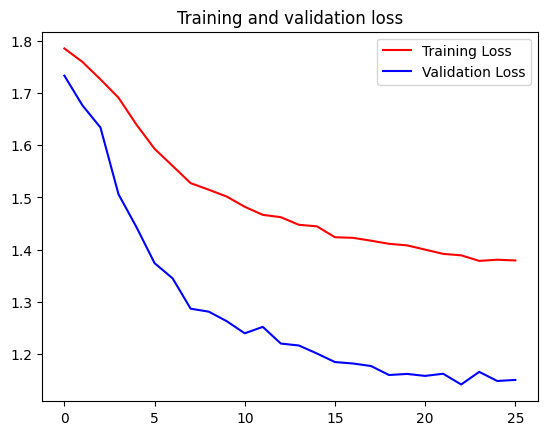

In [22]:
import matplotlib.pyplot as plt

acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc))

plt.plot(epochs, acc, 'r', label = "Training Accuracy")
plt.plot(epochs, val_acc, 'b', label = "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.legend()

plt.show()
print('')

plt.plot(epochs, loss, 'r', label = "Training Loss")
plt.plot(epochs, val_loss, 'b', label = "Validation Loss")
plt.title('Training and validation loss')
plt.legend()

plt.show()

Prediksi gambar yang diupload menggunakan model yg telah dilatih

In [ ]:
uploaded = files.upload()

for fn in uploaded.keys():

  path = fn
  img = load_img(path, target_size=(300, 300))
  x = img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(fn)
  print(classes)

Menyimpan model yang telah dilatih dengan format HDF5

In [ ]:
history.save(filepath)